# Chapter 6 Exercises

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook

from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Make predictions on the simulated ARMA(1,1) process
1. Reusing the simulated ARMA(1,1) process, split it into train and test sets.
Assign 80% of the data to the train set and the remaining 20% to the test set.
2. Use the rolling_forecast function to make predictions using the ARMA(1,1)
model, the mean method, and the last known value method.
3. Plot your forecasts.
4. Evaluate each method’s performance using the MSE. Which method performed best?

**1. Reusing the simulated ARMA(1,1) process, split it into train and test sets. Assign 80% of the data to the train set and the remaining 20% to the test set.**

$$
y_t = -0.33 * y_{t-1} + 0.9 * \epsilon_{t-1} + \epsilon_t
$$

In [6]:
np.random.seed(42)

ar1 = np.array([1, -0.33])  # AR part: coefficients for AR(1)
ma1 = np.array([1, 0.9])    # MA part: coefficients for MA(1)

ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

In [7]:
df = pd.DataFrame({'value': ARMA_1_1})

train = df[:800]   # First 800 points
test = df[800:]    # Last 200 points

print(len(train))
print(len(test))

800
200


**2. Use the rolling_forecast function to make predictions using the ARMA(1,1) model, the mean method, and the last known value method.**

In [9]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARMA':
        pred_ARMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(1,0,1))   # <==== AR(1), I(0), MA(1) parameters
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
            
        return pred_ARMA

In [10]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1   # <==== minimum value by (q)

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA

test.head()

,value,pred_mean,pred_last_value,pred_ARMA
800,1.084218,-0.022669,0.361071,0.146811
801,0.686203,-0.021287,1.084218,1.183808
802,-0.141873,-0.020405,0.686203,-0.255567
803,-0.422585,-0.020556,-0.141873,0.062876
804,-0.989997,-0.021056,-0.422585,-0.571610


**3. Plot your forecasts.**

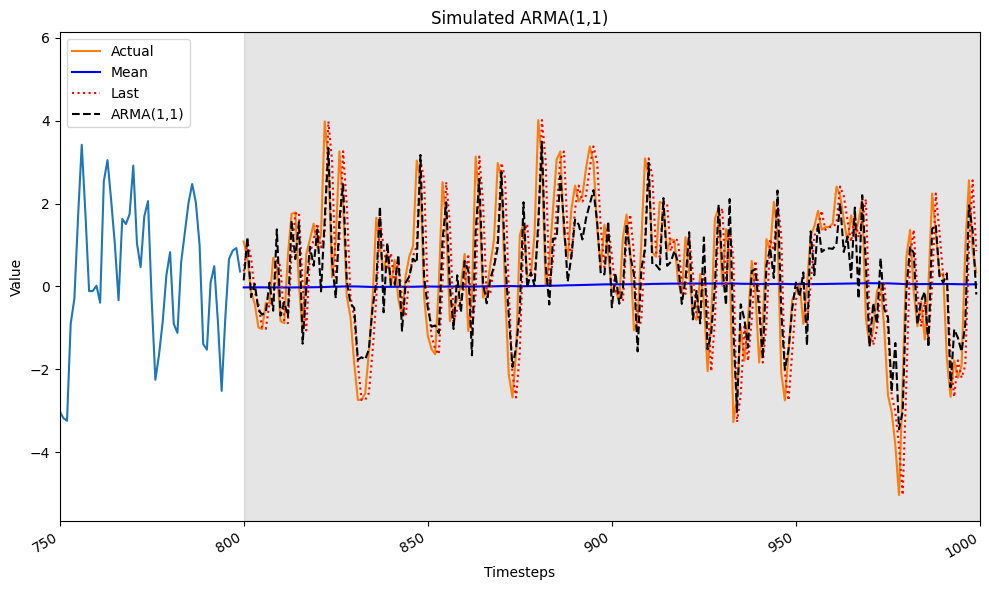

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(train)
ax.plot(test['value'], label='Actual')
ax.plot(test['pred_mean'], 'b-', label='Mean')
ax.plot(test['pred_last_value'], 'r:', label='Last')
ax.plot(test['pred_ARMA'], 'k--', label='ARMA(1,1)')
ax.set_title('Simulated ARMA(1,1)')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

ax.legend(loc='best')

ax.axvspan(800, 1000, color='#808080', alpha=0.2)

plt.xlim(750, 1000)
fig.autofmt_xdate()
plt.tight_layout()

**4. Evaluate each method’s performance using the MSE. Which method performed best?**

In [14]:
# Calculate the MSE for each forecast
mse_mean = mean_squared_error(test['value'], test['pred_mean'])
mse_last = mean_squared_error(test['value'], test['pred_last_value'])
mse_ARMA = mean_squared_error(test['value'], test['pred_ARMA'])

# Display MSE results
print(f'      MSE Mean Forecast: {mse_mean:.2f}')
print(f'MSE Last Value Forecast: {mse_last:.2f}')
print(f' MSE ARMA(1,1) Forecast: {mse_ARMA:.2f}')

      MSE Mean Forecast: 2.68
MSE Last Value Forecast: 1.68
 MSE ARMA(1,1) Forecast: 0.93


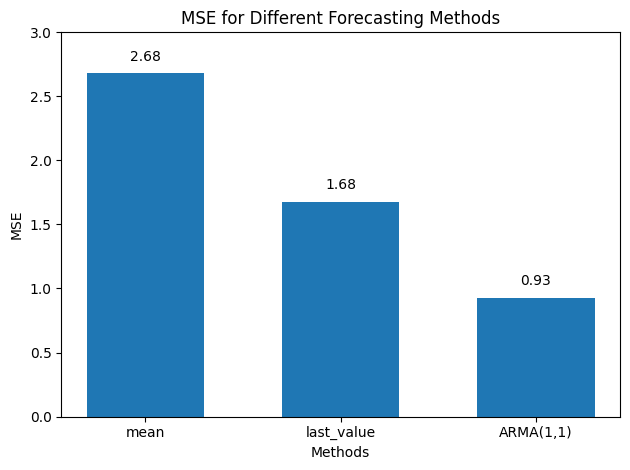

In [15]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'ARMA(1,1)']
y = [mse_mean, mse_last, mse_ARMA]

ax.bar(x, y, width=0.6)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_title('MSE for Different Forecasting Methods')
ax.set_ylim(0, 3)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(round(value, 2)), ha='center')

plt.tight_layout()

ARMA(1,1) has the better performance.

## Simulate an ARMA(2,2) process and make forecasts

Simulate a stationary ARMA(2,2) process. Use the ArmaProcess function from statsmodels and simulate this:

$$
y_t = 0.33 y_{t-1} + 0.50 y_{t-2} + 0.9 \epsilon_{t-1} + 0.3 \epsilon_{t-2}
$$


**1. Simulate 10,000 samples**

In [20]:
np.random.seed(42)

ar2 = np.array([1, -0.33, -0.50])  # AR part: coefficients for AR(2)
ma2 = np.array([1, 0.9, 0.3])      # MA part: coefficients for MA(2)

ARMA_2_2 = ArmaProcess(ar2, ma2).generate_sample(nsample=10000)

**2. Plot your simulated process.**

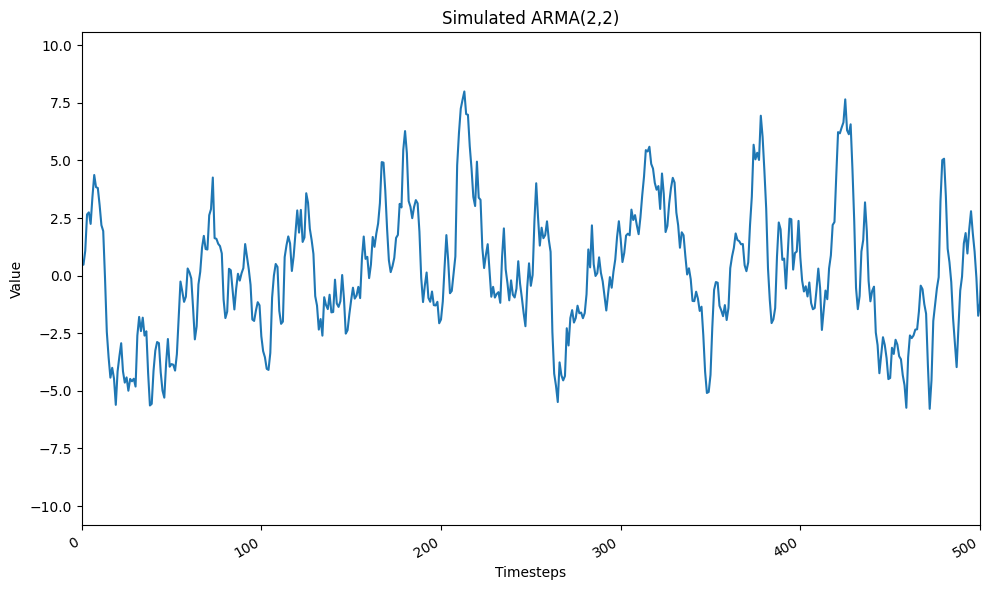

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(ARMA_2_2)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
ax.set_title('Simulated ARMA(2,2)')

plt.xlim(0, 500)

fig.autofmt_xdate()
plt.tight_layout()

**3. Test for stationarity using the ADF test**

In [24]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(ARMA_2_2)

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -20.68489443524329
p-value: 0.0

p-value < alpha; Ha: Stationary


**4. Split your data into train and test sets. The test set must contain the last 200 timesteps. The rest is for the train set.**

In [26]:
df = pd.DataFrame({'value': ARMA_2_2})

train = df[:-200]  # All points less the last 200 timesteps
test = df[-200:]   # The last 200 timesteps

print(len(train))
print(len(test))

9800
200


**5. Define a range of values for p and q, and generate all unique combinations of orders (p,q).**

In [28]:
from typing import Union

# The function takes as inputs the time series data and the list of unique (p,q) combinations
def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)     # Fit an ARMA(p,q) model using SARIMAX
        except:
            continue
            
        aic = model.aic                    # Calculate the model’s AIC.
        results.append([order, aic])       # Append the (p,q) combination and AIC as a tuple to the results list.
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [29]:
ps = range(0, 4, 1)                 # The order p can have the values {0,1,2,3}
qs = range(0, 4, 1)                 # The order q can have the values {0,1,2,3}

order_list = list(product(ps, qs))  # Generate the unique (p,q) combinations
order_list

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3)]

**6. Use the optimize_ARMA function to fit all unique ARMA(p,q) models, and
select the one with the lowest AIC. Is the ARMA(2,2) model the one with the
lowest AIC?**

In [31]:
# Pass 'train dataset' and 'order_list' on 'optimize_ARMA'
result_df = optimize_ARMA(train['value'], order_list)  
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 2)",27905.101691
1,"(2, 3)",27905.310112
2,"(2, 2)",27905.573367
3,"(3, 3)",27907.356959
4,"(1, 3)",27917.375642
5,"(1, 2)",27965.143311
6,"(3, 1)",27984.569852
7,"(3, 0)",28008.899430
8,"(2, 1)",28010.581548
9,"(2, 0)",28011.840379


Just like in the chapter, we see that an ARMA(3,2) or ARMA(2,3) have a slightly lower AIC, however we are looking at the decimal places. Here, we can reasonably go with the ARMA(2,2) model and have accurate predictions.

**7. Select the best model according to the AIC, and store the residuals in a variable called residuals.**

In [34]:
# Define a SARIMAX model with specified AR(2), I(0), MA(2) parameters
model = SARIMAX(train['value'], order=(2,0,2), simple_differencing=False)

# Fit the model
model_fit = model.fit(disp=False)

# Display the summary
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                 9800
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -13947.787
Date:                Thu, 13 Feb 2025   AIC                          27905.573
Time:                        16:21:36   BIC                          27941.524
Sample:                             0   HQIC                         27917.755
                               - 9800                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3470      0.052      6.721      0.000       0.246       0.448
ar.L2          0.4757      0.048     10.010      0.000       0.383       0.569
ma.L1          0.8683      0.050     17.244      0.000       0.770       0.967
ma.L2          0.2808      0.015     19.191      0.000       0.252       0.309
sigma2         1.0084      0.014     70.558      0.000       0.980       1.036
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 0.52
Prob(Q):                              0.84   Prob(JB):                         0.77
Heteroskedasticity (H):               1.06   Skew:                            -0.00
Prob(H) (two-sided):                  0.12   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit.resid 

**8. Perform a qualitative analysis of the residuals with the plot_diagnostics
method. Does the Q-Q plot show a straight line that lies on y = x? Does the correlogram show significant coefficients?**

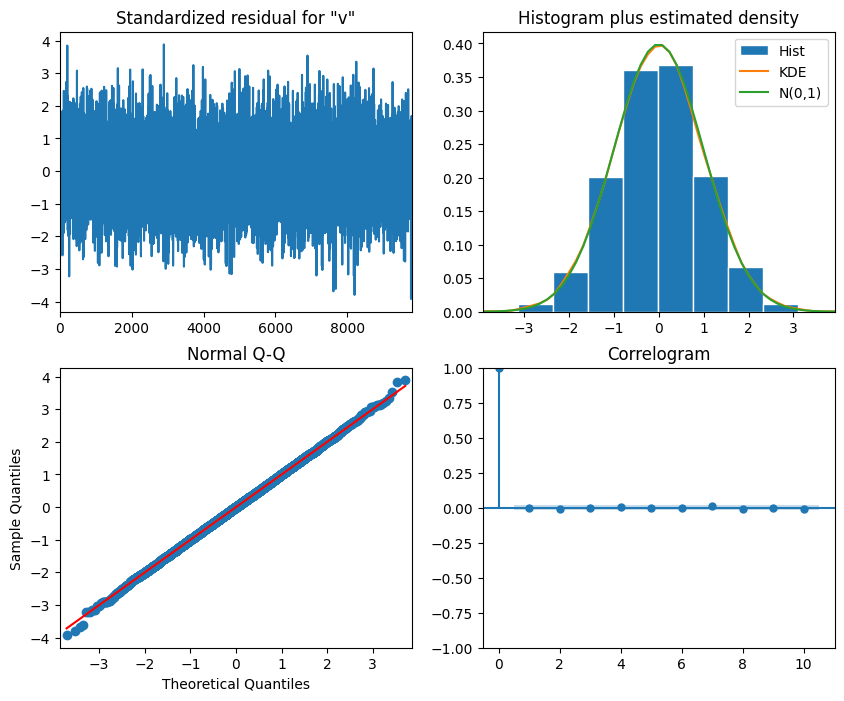

In [37]:
# Diagnostic plots for the model, including residuals and other model checks
model_fit.plot_diagnostics(figsize=(10, 8));

    Does the Q-Q plot show a straight line that lies on y = x? YES.
           Does the correlogram show significant coefficients? NO.

**9. Perform a quantitative analysis of the residuals by applying the Ljung-Box test
on the first 10 lags. Are all returned p-values above 0.05? Are the residuals correlated or not**?

In [40]:
# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

df_residuals

,lb_stat,lb_pvalue
1,0.042296,0.837056
2,0.414491,0.812820
3,0.514013,0.915802
4,0.819529,0.935811
5,0.819685,0.975761
6,1.075739,0.982577
7,2.077897,0.955403
8,3.083728,0.928994
9,3.102822,0.960078
10,3.415384,0.969894


    P-value > 0.05; H0: Residuals are independetly distributed and uncorrelated.

**10. Use the rolling_forecast function to make predictions using the selected
ARMA(p,q) model, the mean method, and the last known value method.**

In [43]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARMA':
        pred_ARMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,0,2))    # <==== AR(2), I(0), MA(2) parameters
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
            
        return pred_ARMA

In [44]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2  # <==== minimum value by (q)

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA

test.head()

,value,pred_mean,pred_last_value,pred_ARMA
9800,-0.275170,-0.025645,-0.837188,-1.182182
9801,0.479336,-0.025645,-0.837188,-1.137223
9802,3.059285,-0.025619,0.479336,0.736508
9803,2.459694,-0.025619,0.479336,0.627930
9804,2.941582,-0.025051,2.459694,2.100925


**11. Plot your forecasts.**

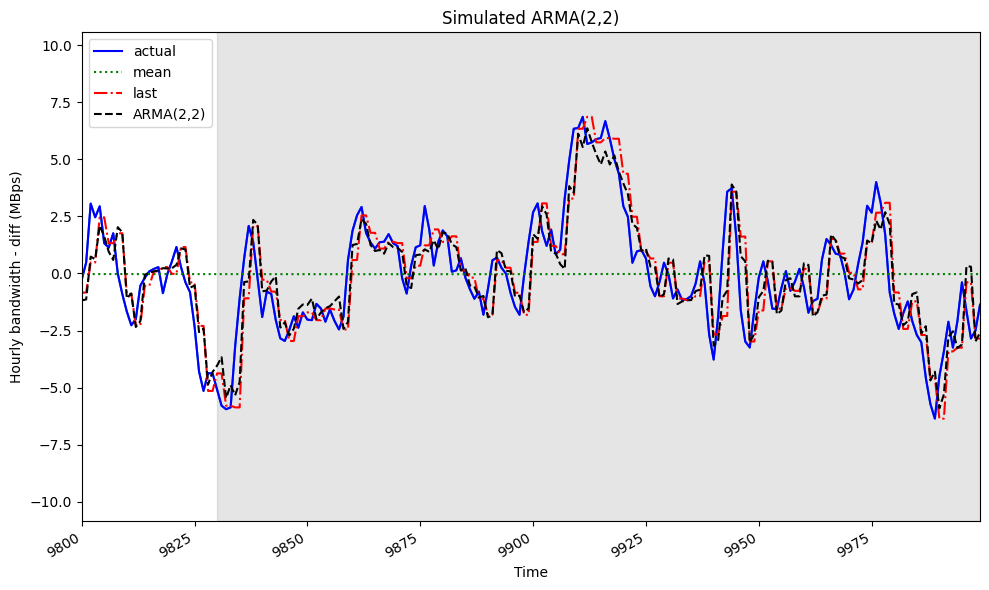

In [46]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df['value'])
ax.plot(test['value'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_ARMA'], 'k--', label='ARMA(2,2)')
ax.set_title('Simulated ARMA(2,2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth - diff (MBps)')

ax.axvspan(9830, 9999, color='#808080', alpha=0.2)

ax.set_xlim(9800, 9999)

fig.autofmt_xdate()
plt.tight_layout()

**12. Evaluate each method’s performance using the MSE. Which method performed best?**

In [48]:
# Calculate the MSE for each forecast
mse_mean = mean_squared_error(test['value'], test['pred_mean'])
mse_last = mean_squared_error(test['value'], test['pred_last_value'])
mse_ARMA = mean_squared_error(test['value'], test['pred_ARMA'])

# Display MSE results
print(f'      MSE Mean Forecast: {mse_mean:.2f}')
print(f'MSE Last Value Forecast: {mse_last:.2f}')
print(f' MSE ARMA(2,2) Forecast: {mse_ARMA:.2f}')

      MSE Mean Forecast: 6.26
MSE Last Value Forecast: 2.16
 MSE ARMA(2,2) Forecast: 1.76


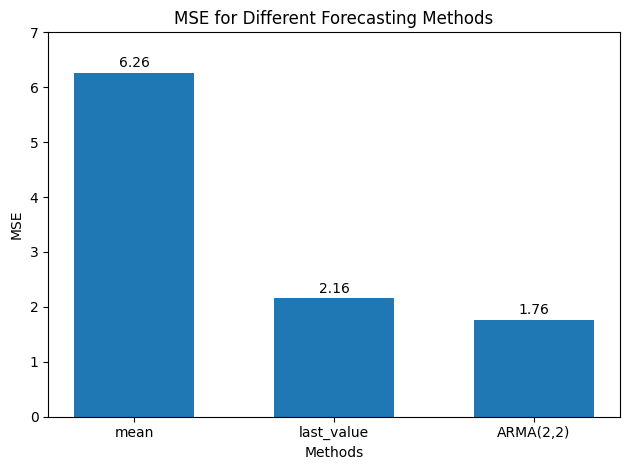

In [49]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'ARMA(2,2)']
y = [mse_mean, mse_last, mse_ARMA]

ax.bar(x, y, width=0.6)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_title('MSE for Different Forecasting Methods')
ax.set_ylim(0, 7)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(round(value, 2)), ha='center')

plt.tight_layout()

The forecasting method that performs best is ARMA(2,2).